# _LDC1-3: Verification Galactic Binaries Tutorial_

The data files and codes used in this tutorial can be found on the LISA Data Challenge website:
* files: https://lisa-ldc.lal.in2p3.fr/file
* codes: https://lisa-ldc.lal.in2p3.fr/code (available soon)

### 1. Importing needed packages

In [1]:
import numpy as np
import sys, os
import time

from LISAhdf5 import LISAhdf5,ParsUnits
import tdi
import FastGB as FB

import matplotlib.pyplot as plt
import matplotlib as mpl
import pandas as pd

import LISAConstants as LC

### 2. Definition of waveform generator function

In [2]:
def GenerateFastGB(p, TD = False):
    #{{{
    ### unfolding the parameters and producing the list of Params
    Amp = p.get("Amplitude")
    f0 = p.get("Frequency")
    fdot = p.get("FrequencyDerivative")
    iota = p.get("Inclination")
    psi = p.get("Polarization")
    phi0 = p.get("InitialPhase")
    EclLat = p.getConvert('EclipticLatitude',LC.convAngle,'rad')
    EclLon = p.getConvert('EclipticLongitude',LC.convAngle,'rad')

    Tobs = float(p.get("ObservationDuration"))
    del_t = float(p.get("Cadence"))
    Ns = len(Amp)
    # print (Tobs, del_t, Ns)
    prm = []
    for i in range(Ns):
        tmp = np.array([f0[i], fdot[i], EclLat[i], EclLon[i], Amp[i], iota[i], psi[i], phi0[i]])
        prm.append(tmp)
    fastB = FB.FastGB("Test", dt=del_t, Tobs=Tobs, orbit="analytic")

    if TD:
        Xt, Yt, Zt = fastB.TDI(T=Tobs,dt=del_t,simulator='synthlisa',table=prm,
        algorithm='Michele',oversample=4)
        tm = np.arange(len(Xt))*del_t

        return (tm, Xt, Yt, Zt)

    else:
        Xf, Yf, Zf = fastB.fourier(T=Tobs,dt=del_t,simulator='synthlisa',
        table=prm,algorithm='Michele',oversample=4)
        return(Xf.f,Xf[:],Yf[:],Zf[:])
    
def Window(tm):

    xl = 1000.0
    ind_r = np.argwhere(tm[-1]-tm <= 1000.0)[0][0]
    xr = tm[ind_r]
    # print (xr)
    kap = 0.005
    winl = 0.5*(1.0 + np.tanh(kap*(tm-xl)))
    winr = 0.5*(1.0 - np.tanh(kap*(tm-xr)))
    # plt.plot(tm, winl)
    # plt.plot(tm, winr)
    # plt.grid(True)
    # plt.show()
    return (winl*winr)

### 3. Reading hdf5 data file

In [3]:
# Specify the hdf5 file path
hdf5_path = "/Users/qbaghi/Codes/data/LDC/LDC1-3_VGB_v1_FD_noiseless.hdf5"
# Open the file with the dedicated LISAhdf5 module
FD5 =  LISAhdf5(hdf5_path)
# Number of sources
Nsrc = FD5.getSourcesNum()
# Types of sources
GWs = FD5.getSourcesName()
print ("Found %d GW sources: " % Nsrc, GWs)
# Get source parameters
p = FD5.getSourceParameters(GWs[0])
# Get the time delay interferometry data
td = FD5.getPreProcessTDI()
# Sampling time
del_t = float(p.get("Cadence"))
# Observation duration
Tobs = float(p.get("ObservationDuration"))
# Display the source parameters
p.display()

Found 1 GW sources:  ['GalBinaries']
	Amplitude [1.07345e-22 1.36368e-22 1.76276e-22 7.34608e-23 1.50933e-22 5.35906e-23
 3.29570e-23 7.39547e-23 6.37823e-23 1.66997e-22] [strain]
	Cadence 15.0 [Seconds]
	EclipticLatitude [ 0.312414  -0.529009   0.0865683  0.490263   0.653451  -0.354825
  0.816989   0.490263  -0.082205   0.101404 ] [Radian]
	EclipticLongitude [-2.75291 -2.51031 -2.18009  2.28603  2.97387  0.4297  -1.13534  2.28603
  2.10225  1.76872] [Radian]
	Frequency [0.00135962 0.00125313 0.00181324 0.00166667 0.00194414 0.00322061
 0.0035125  0.0016835  0.00622028 0.00261301] [Hz]
	FrequencyDerivative [8.94581279e-19 9.15958730e-19 2.04973995e-18 2.18905890e-18
 6.48972578e-18 1.74586691e-17 2.78570006e-17 2.27120824e-18
 7.48528554e-16 2.90562842e-17] [Hz^2]
	Inclination [0.523599   0.244346   0.523599   1.22173    0.750492   1.6169347
 1.5063286  1.67948105 0.645772   1.51669   ] [Radian]
	InitialPhase [3.0581565  2.64414439 2.97459105 3.2219877  3.00689165 2.84090075
 3.1855139

#### 3.1 Plot de TDI data in the time domain

(4194304, 4)


<Figure size 432x288 with 0 Axes>

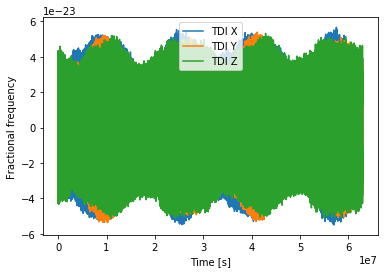

In [4]:
Npts = 2**22
print(np.shape(td))
#df1 = pd.DataFrame(td[:Npts,1:],index = td[:Npts,0], columns=['TDI X', 'TDI Y', 'TDI Z'])
df1 = pd.DataFrame(td[:Npts,:],columns=['Time','TDI X', 'TDI Y', 'TDI Z'])
plt.figure(1)
df1.plot(x = 'Time',y = ['TDI X', 'TDI Y', 'TDI Z'])
plt.xlabel("Time [s]")
plt.ylabel("Fractional frequency")
plt.legend(loc='best')

#### 3.2 Plot the TDI data in the frequency domain

<Figure size 432x288 with 0 Axes>

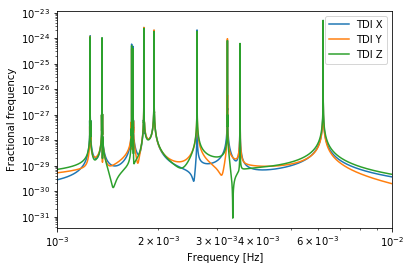

In [12]:
# Create a new data matrix for fourier-transformed data
td_freq = np.zeros(np.shape(td),dtype = np.complex128)
# Tapering window to mitigate leakage
#wind = Window(td[:Npts,0])
wind = np.hamming(Npts)
# Take discrete Fourier transform of the noiseless data
td_freq[:,1:] = np.array( [ np.fft.fft(td[:Npts,i]*wind,axis = 0) for i in range(1,4)] ).T
# Compute corresponding frequency vector
freq = np.fft.fftfreq(Npts)/del_t
td_freq[:,0] = freq
# Store the amplitude modulus in data frame (positive frequencies)
td_freq_plot = np.zeros(np.shape(td_freq[freq>0,:]),dtype = np.float64) 
td_freq_plot[:,0] = freq[freq>0]
td_freq_plot[:,1:] = np.abs(td_freq[freq>0,1:])*2/np.sum(wind)
df2 = pd.DataFrame(td_freq_plot,columns=['freq','TDI X', 'TDI Y', 'TDI Z'])
# Plot the Fourier amplitudes
plt.figure(2)
df2.plot(x = 'freq',y = ['TDI X', 'TDI Y', 'TDI Z'],logx=True,logy=True)
plt.xlabel("Frequency [Hz]")
plt.ylabel("Fractional frequency")
plt.xlim(1e-3,1e-2)
plt.legend(loc='best')


### 4. Reproducing the signal in frequency domain: fast waveform generation


#### 4.1 Generate waveform in frequency domain using FastGB

In [13]:
dTDI_FD = GenerateFastGB(p)
# Prepare the data for plotting
dTDI_FD = np.array(dTDI_FD).T
dTDI_FD[:,1:] = dTDI_FD[:,1:]*2


Stas <class 'int'> <class 'int'> <class 'float'>
10 finished, 0 s elapsed (1132/s)


#### 4.2 Verify consistency with the LDC data set

<Figure size 432x288 with 0 Axes>

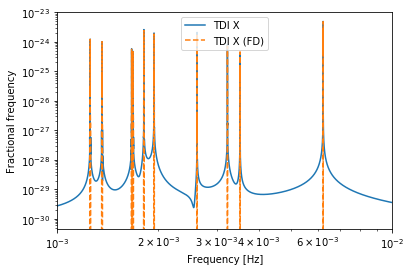

In [14]:
df3 = pd.DataFrame(np.abs(dTDI_FD),columns=['f','TDI X (FD)', 'TDI Y (FD)', 'TDI Z (FD)'])
# Plot the Fourier amplitudes
plt.figure(3)
ax = df2.plot(x = 'freq',y = 'TDI X',logx = True,logy=True)
df3.plot(x = 'f', y = 'TDI X (FD)',ax = ax, logx = True,logy=True,style='--')
plt.xlabel("Frequency [Hz]")
plt.ylabel("Fractional frequency")
plt.xlim(1e-3,1e-2)
plt.legend(loc='best')

### 5. Generate the signal in the time domain using LISACode: full simulation

In [16]:
# Duplicate the hdf5 file
hdf5_path_TD = hdf5_path[:-5]+"_TD.hdf5"
FD5_TD =  LISAhdf5(hdf5_path_TD)
FD5_TD.addSource(GWs[0], p, overwrite=True)
# os.system("cp  " + hdf5_path + "  " + hdf5_path_TD )

#### 5.1 Compute h+, hx

In [17]:
# Set the path where the MLDC scripts are located
script_path = "/Users/qbaghi/Codes/MLDC/software/LDCpipeline/scripts/"
# Compute the strain polarizations in source frame
os.system("python "+ script_path + "Compute_hphc.py  " + hdf5_path_TD)

0

####  5.2 Configure the LISA instrument

In [18]:
dt = p.get("Cadence")
Tobs = p.get("ObservationDuration")
os.system("python "+script_path+"ConfigureInstrument.py  --duration="+str(Tobs)+"  --timeStep="+ str(dt) +"  --orbits='MLDC_Orbits'  " + hdf5_path_TD)

0

####  5.3 Configure the noises

In [19]:
os.system("python "+script_path+"ConfigureNoises.py  " + hdf5_path_TD)

0

#### 5.4 Run the simulation
**Important note:** If the execution of the code in the cell below fails, you may need to place RunSimu2.py and the hdf5 file in the same directory and run the command without indicating the script path:
```python
os.system("python RunSimuLC2.py  --NoNoise  --path2LISACode="+path2LISACode+" --seed=" + str(seed) + "  -v  "  + hdf5_path_TD)
```

In [20]:
seed = 3
path2LISACode = "/Users/qbaghi/local/lisacode/bin/"
os.system("python "+script_path+"RunSimuLC2.py  --NoNoise  --path2LISACode="+path2LISACode+" --seed=" + str(seed) + "  -v  "  + hdf5_path_TD)

0

#### 5.5 Get the results

<Figure size 432x288 with 0 Axes>

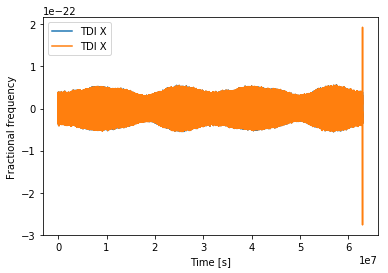

In [21]:
FD5_TD =  LISAhdf5(hdf5_path_TD)
dTDI_TD = FD5_TD.getPreProcessTDI()
df4 = pd.DataFrame(dTDI_TD,columns=['t','TDI X (TD)', 'TDI Y (TD)', 'TDI Z (TD)'])
plt.figure(4)
df4.plot(x = 't',y = ['TDI X (TD)'])
plt.xlabel("Time [s]")
plt.ylabel("Fractional frequency")
plt.legend(loc='best')

#### 5.6 Fourier transform them

In [22]:
# Create a new data matrix for fourier-transformed data
dTDI_TD_fft = np.zeros(np.shape(dTDI_TD[:Npts,:]),dtype = np.complex128)
# Take discrete Fourier transform of the data
dTDI_TD_fft[:,1:] = np.array( [ np.fft.fft(dTDI_TD[:Npts,i]*wind,axis = 0) for i in range(1,4)] ).T
# Compute corresponding frequency vector
freq = np.fft.fftfreq(Npts)/del_t
dTDI_TD_fft[:,0] = freq
# Store the amplitude modulus in data frame (positive frequencies)
dTDI_TD_fft_plot = np.zeros(np.shape(dTDI_TD_fft[freq>0,:]),dtype = np.float64)  
dTDI_TD_fft_plot[:,0] = freq[freq>0]
dTDI_TD_fft_plot[:,1:] = np.abs(dTDI_TD_fft[freq>0,1:])*2/np.sum(wind)
df5 = pd.DataFrame(dTDI_TD_fft_plot,columns=['freq','TDI X (TD)', 'TDI Y (TD)', 'TDI Z (TD)'])

#### 5.7 Plot time-domain simulation and frequency-domain waveforms

<Figure size 432x288 with 0 Axes>

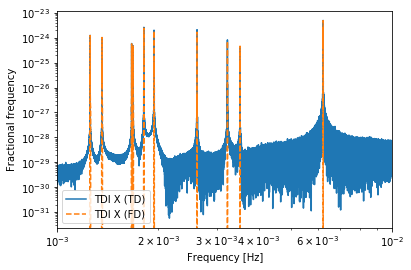

In [23]:
plt.figure(4)
ax4 = df5.plot(x = 'freq',y = 'TDI X (TD)',logx = True,logy=True)
df3.plot(x = 'f', y = 'TDI X (FD)',ax = ax4, logx = True,logy=True,style='--')
plt.xlabel("Frequency [Hz]")
plt.ylabel("Fractional frequency")
plt.xlim(1e-3,1e-2)
plt.legend(loc='best')